# Settings

In [1]:
import os, json, math, shutil
import numpy as np
import tensorflow as tf
# environment variables used by bash cells
PROJECT=!(gcloud config get-value project)
PROJECT=PROJECT[0]
REGION = 'us-central1'
BUCKET='{}-dsongcp'.format(PROJECT)
os.environ['ENDPOINT_NAME'] = 'flights'
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TF_VERSION']='2-' + tf.__version__[2:3]

In [2]:
!ls

Untitled.ipynb	src  tutorials


# Load data

*When the lab spins up, a few tables are created in the BigQuery dataset. In this section, you use BigQuery to create temporary tables in BigQuery that contain the data we need, and then export the table to CSV files on Google Cloud Storage. You then delete the temporary table. Moving further, read and process those CSV data files to create the training, validation, and full datasets you need for a custom TensorFlow model.*

## Create training dataset flights_train_data for model training

In [3]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_train_data AS
SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False AND
  is_train_day = 'True'

Query is running:   0%|          |

""


## Create the evaluation dataset flights_eval_data for model evaluation

In [4]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_eval_data AS
SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False AND
  is_train_day = 'False'

Query is running:   0%|          |

""


## Create the full dataset flights_all_data using the following code

In [5]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_all_data AS
SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon,
  IF (is_train_day = 'True',
      IF(ABS(MOD(FARM_FINGERPRINT(CAST(f.FL_DATE AS STRING)), 100)) < 60, 'TRAIN', 'VALIDATE'),
      'TEST') AS data_split
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False

Query is running:   0%|          |

""


## Export the training, validation, and full datasets to CSV file format the Google Cloud Storage bucket

In [6]:
%%bash
PROJECT=$(gcloud config get-value project)
for dataset in "train" "eval" "all"; do
  TABLE=dsongcp.flights_${dataset}_data
  CSV=gs://${BUCKET}/ch9/data/${dataset}.csv
  echo "Exporting ${TABLE} to ${CSV} and deleting table"
  bq --project_id=${PROJECT} extract --destination_format=CSV $TABLE $CSV
  bq --project_id=${PROJECT} rm -f $TABLE
done

Exporting dsongcp.flights_train_data to gs://qwiklabs-gcp-02-f1ad54b83ac0-dsongcp/ch9/data/train.csv and deleting table


Waiting on bqjob_r207c5e83d2bad449_0000018ad19a3876_1 ... (48s) Current status: DONE   


Exporting dsongcp.flights_eval_data to gs://qwiklabs-gcp-02-f1ad54b83ac0-dsongcp/ch9/data/eval.csv and deleting table


Waiting on bqjob_r36ec36e14b61d1ae_0000018ad19b071f_1 ... (10s) Current status: DONE   


Exporting dsongcp.flights_all_data to gs://qwiklabs-gcp-02-f1ad54b83ac0-dsongcp/ch9/data/all.csv and deleting table


Waiting on bqjob_r5eed9ee14a90aec0_0000018ad19b3e9a_1 ... (108s) Current status: DONE   


In [7]:
!gsutil ls -lh gs://{BUCKET}/ch9/data

445.01 MiB  2023-09-26T13:10:13Z  gs://qwiklabs-gcp-02-f1ad54b83ac0-dsongcp/ch9/data/all.csv
115.19 MiB  2023-09-26T13:08:43Z  gs://qwiklabs-gcp-02-f1ad54b83ac0-dsongcp/ch9/data/eval.csv
296.96 MiB  2023-09-26T13:08:24Z  gs://qwiklabs-gcp-02-f1ad54b83ac0-dsongcp/ch9/data/train.csv
TOTAL: 3 objects, 898801258 bytes (857.16 MiB)


# Data preparation

In [8]:
DEVELOP_MODE = True
NUM_EXAMPLES = 5000*1000

training_data_uri = 'gs://{}/ch9/data/train*'.format(BUCKET)
validation_data_uri = 'gs://{}/ch9/data/eval*'.format(BUCKET)

NBUCKETS = 5
NEMBEDS = 3
TRAIN_BATCH_SIZE = 64
DNN_HIDDEN_UNITS = '64,32'

In [9]:
if DEVELOP_MODE:
    train_df = tf.data.experimental.make_csv_dataset(training_data_uri, batch_size=5)
    for n, data in enumerate(train_df):
        numpy_data = {k: v.numpy() for k, v in data.items()}
        print(n, numpy_data)
        if n==1: break

2023-09-26 13:15:10.702236: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-09-26 13:15:10.702283: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-26 13:15:10.702317: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow): /proc/driver/nvidia/version does not exist
2023-09-26 13:15:10.704825: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 13:15

0 {'ontime': array([1, 1, 1, 1, 1], dtype=int32), 'dep_delay': array([ 0, -3,  6,  0,  3], dtype=int32), 'taxi_out': array([11, 15, 12, 12, 15], dtype=int32), 'distance': array([ 519, 2296,  836,  475,  224], dtype=int32), 'origin': array([b'LAS', b'CLT', b'DEN', b'ORD', b'SEA'], dtype=object), 'dest': array([b'BOI', b'SFO', b'GEG', b'TYS', b'GEG'], dtype=object), 'dep_hour': array([16, 21,  4, 23,  0], dtype=int32), 'is_weekday': array([1, 0, 1, 1, 1], dtype=int32), 'carrier': array([b'WN', b'US', b'WN', b'EV', b'OO'], dtype=object), 'dep_airport_lat': array([36.08    , 35.21361 , 39.861668, 41.979443, 47.45    ],
      dtype=float32), 'dep_airport_lon': array([-115.15222 ,  -80.949165, -104.67306 ,  -87.9075  , -122.31167 ],
      dtype=float32), 'arr_airport_lat': array([43.564445, 37.61889 , 47.619167, 35.810833, 47.619167],
      dtype=float32), 'arr_airport_lon': array([-116.22278, -122.375  , -117.53528,  -83.99416, -117.53528],
      dtype=float32)}
1 {'ontime': array([1, 1, 1,

The `read_dataset()` function reads the training data, yielding `batch_size` examples each time, and allows you to stop iterating once a certain number of examples have been read.

The dataset contains all the columns in the CSV file, named according to the header line. The data consists of both features and the label. It’s better to separate them by writing the `features_and_labels()` function to make the later code easier to read. Hence, we’ll apply a `pop()` function to the dictionary and return a tuple of features and labels).

In [10]:
def features_and_labels(features):
  label = features.pop('ontime') 
  return features, label

def read_dataset(pattern, batch_size, mode=tf.estimator.ModeKeys.TRAIN, truncate=None):
  dataset = tf.data.experimental.make_csv_dataset(pattern, batch_size, num_epochs=1)
  dataset = dataset.map(features_and_labels)
  if mode == tf.estimator.ModeKeys.TRAIN:
    dataset = dataset.shuffle(batch_size*10)
    dataset = dataset.repeat()
  dataset = dataset.prefetch(1)
  if truncate is not None:
    dataset = dataset.take(truncate)
  return dataset
if DEVELOP_MODE:
    print("Checking input pipeline")
    one_item = read_dataset(training_data_uri, batch_size=2, truncate=1)
    print(list(one_item)) # should print one batch of 2 items

Checking input pipeline
[(OrderedDict([('dep_delay', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([-10,  -5], dtype=int32)>), ('taxi_out', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 8, 14], dtype=int32)>), ('distance', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 620, 2419], dtype=int32)>), ('origin', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'PSC', b'IAD'], dtype=object)>), ('dest', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'SFO', b'SFO'], dtype=object)>), ('dep_hour', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([12,  2], dtype=int32)>), ('is_weekday', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>), ('carrier', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'OO', b'UA'], dtype=object)>), ('dep_airport_lat', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([46.26472, 38.9475 ], dtype=float32)>), ('dep_airport_lon', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-119.11916,  -77.46   ], dtype=float32)>), ('a

# Model creation and training

*Typically you create one feature for every column in our tabular data. Keras supports feature columns, opening up the ability to represent structured data using standard feature engineering techniques like embedding, bucketizing, and feature crosses. As numeric data can be passed in directly to the ML model, keep the real-valued columns separate from the sparse (or string) columns.*

In [12]:
import tensorflow as tf
real = {
    colname : tf.feature_column.numeric_column(colname) 
          for colname in 
            (
                'dep_delay,taxi_out,distance,dep_hour,is_weekday,' +
                'dep_airport_lat,dep_airport_lon,' +
                'arr_airport_lat,arr_airport_lon'
            ).split(',')
}
sparse = {
      'carrier': tf.feature_column.categorical_column_with_vocabulary_list('carrier',
                  vocabulary_list='AS,VX,F9,UA,US,WN,HA,EV,MQ,DL,OO,B6,NK,AA'.split(',')),
      'origin' : tf.feature_column.categorical_column_with_hash_bucket('origin', hash_bucket_size=1000),
      'dest'   : tf.feature_column.categorical_column_with_hash_bucket('dest', hash_bucket_size=1000),
}

All these features come directly from the input file (and are provided by any client that wants a prediction for a flight). Input layers map 1:1 to the input features and their types, so rather than repeat the column names, you create an input layer for each of these columns, specifying the right data type (either a float or a string).

In [13]:
inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') 
          for colname in real.keys()
}
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string') 
          for colname in sparse.keys()
})

## Bucketing

Real-valued columns whose precision is overkill (thus, likely to cause overfitting) can be discretized and made into categorical columns. For example, if you have a column for the age of the aircraft, you might discretize into just three bins—less than 5 years old, 5 to 20 years old, and more than 20 years old. Use the discretization shortcut: you can discretize the latitudes and longitudes and cross the buckets—this results in breaking up the country into grids and yield the grid point into which a specific latitude and longitude falls.

In [14]:
latbuckets = np.linspace(20.0, 50.0, NBUCKETS).tolist()  # USA
lonbuckets = np.linspace(-120.0, -70.0, NBUCKETS).tolist() # USA
disc = {}
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], latbuckets) 
          for key in ['dep_airport_lat', 'arr_airport_lat']
})
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], lonbuckets) 
          for key in ['dep_airport_lon', 'arr_airport_lon']
})
# cross columns that make sense in combination
sparse['dep_loc'] = tf.feature_column.crossed_column(
    [disc['d_dep_airport_lat'], disc['d_dep_airport_lon']], NBUCKETS*NBUCKETS)
sparse['arr_loc'] = tf.feature_column.crossed_column(
    [disc['d_arr_airport_lat'], disc['d_arr_airport_lon']], NBUCKETS*NBUCKETS)
sparse['dep_arr'] = tf.feature_column.crossed_column([sparse['dep_loc'], sparse['arr_loc']], NBUCKETS ** 4)
# embed all the sparse columns
embed = {
       'embed_{}'.format(colname) : tf.feature_column.embedding_column(col, NEMBEDS)
          for colname, col in sparse.items()
}
real.update(embed)
# one-hot encode the sparse columns
sparse = {
    colname : tf.feature_column.indicator_column(col)
          for colname, col in sparse.items()
}
if DEVELOP_MODE:
    print(sparse.keys())
    print(real.keys())

dict_keys(['carrier', 'origin', 'dest', 'dep_loc', 'arr_loc', 'dep_arr'])
dict_keys(['dep_delay', 'taxi_out', 'distance', 'dep_hour', 'is_weekday', 'dep_airport_lat', 'dep_airport_lon', 'arr_airport_lat', 'arr_airport_lon', 'embed_carrier', 'embed_origin', 'embed_dest', 'embed_dep_loc', 'embed_arr_loc', 'embed_dep_arr'])


## Train & Evaluate the model

In [15]:
output_dir='gs://{}/ch9/trained_model'.format(BUCKET)
os.environ['OUTDIR'] = output_dir  # needed for deployment
print('Writing trained model to {}'.format(output_dir))

Writing trained model to gs://qwiklabs-gcp-02-f1ad54b83ac0-dsongcp/ch9/trained_model


In [16]:
!gsutil -m rm -rf $OUTDIR

CommandException: 1 files/objects could not be removed.


This reports an error stating `CommandException: 1 files/objects could not be removed` because the model has not yet been saved. The error indicates that there are no files present in the target location. You must be certain that this location is empty before attempting to save the model and this command guarantees that.

With the sparse and real feature columns thus enhanced beyond the raw inputs, you can create a `wide_and_deep_classifier` passing in the linear and deep feature columns separately.

In [20]:
# Build a wide-and-deep model.
def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns, name='deep_inputs')(inputs)
    layers = [int(x) for x in dnn_hidden_units.split(',')]
    for layerno, numnodes in enumerate(layers):
        deep = tf.keras.layers.Dense(numnodes, activation='relu', name='dnn_{}'.format(layerno+1))(deep)        
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns, name='wide_inputs')(inputs)
    both = tf.keras.layers.concatenate([deep, wide], name='both')
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    
model = wide_and_deep_classifier(
    inputs,
    linear_feature_columns = sparse.values(),
    dnn_feature_columns = real.values(),
    dnn_hidden_units = DNN_HIDDEN_UNITS)
tf.keras.utils.plot_model(model, 'flights_model.png', show_shapes=False, rankdir='LR')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Training

In [21]:
# training and evaluation dataset
train_batch_size = TRAIN_BATCH_SIZE
if DEVELOP_MODE:
    eval_batch_size = 100
    steps_per_epoch = 3
    epochs = 2
    num_eval_examples = eval_batch_size*10
else:
    eval_batch_size = 100
    steps_per_epoch = NUM_EXAMPLES // train_batch_size
    epochs = 10
    num_eval_examples = eval_batch_size * 100
train_dataset = read_dataset(training_data_uri, train_batch_size)
eval_dataset = read_dataset(validation_data_uri, eval_batch_size, tf.estimator.ModeKeys.EVAL, num_eval_examples)
checkpoint_path = '{}/checkpoints/flights.cpt'.format(output_dir)
shutil.rmtree(checkpoint_path, ignore_errors=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(train_dataset, 
                    validation_data=eval_dataset,
                    epochs=epochs, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[cp_callback])

Epoch 1/2
3/3 [==============================] - 11s 3s/step - loss: 1.1873 - accuracy: 0.5208 - val_loss: 1.0050 - val_accuracy: 0.8187

Epoch 00001: saving model to gs://qwiklabs-gcp-02-f1ad54b83ac0-dsongcp/ch9/trained_model/checkpoints/flights.cpt
Epoch 2/2
3/3 [==============================] - 5s 3s/step - loss: 1.1190 - accuracy: 0.8073 - val_loss: 1.2642 - val_accuracy: 0.8189

Epoch 00002: saving model to gs://qwiklabs-gcp-02-f1ad54b83ac0-dsongcp/ch9/trained_model/checkpoints/flights.cpt


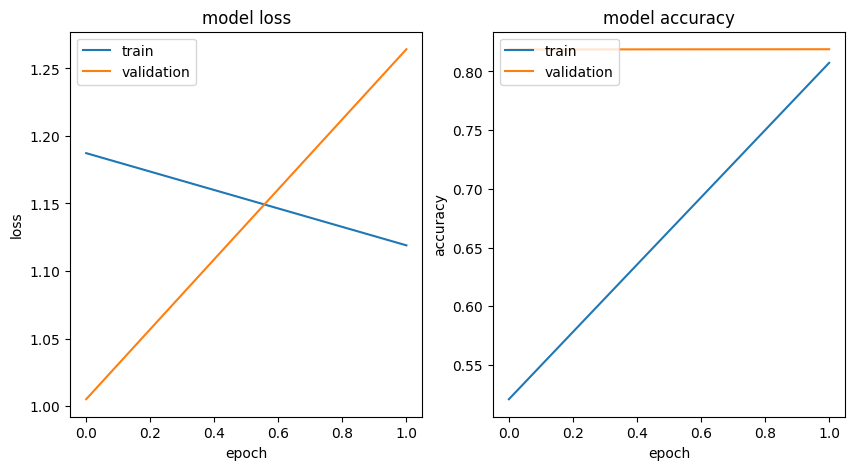

In [22]:
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))
for idx, key in enumerate(['loss', 'accuracy']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Export the trained model

In [23]:
import time
export_dir = '{}/export/flights_{}'.format(output_dir, time.strftime("%Y%m%d-%H%M%S"))
print('Exporting to {}'.format(export_dir))
tf.saved_model.save(model, export_dir)

Exporting to gs://qwiklabs-gcp-02-f1ad54b83ac0-dsongcp/ch9/trained_model/export/flights_20230926-133027


2023-09-26 13:30:31.163595: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://qwiklabs-gcp-02-f1ad54b83ac0-dsongcp/ch9/trained_model/export/flights_20230926-133027/assets


# Deployment of the flights model to Vertex AI

Vertex AI provides a fully managed, autoscaling, serverless environment for Machine Learning models. You get the benefits of paying for any compute resources (such as CPUs or GPUs) only when you are using them. Because the models are containerized, dependency management is taken care of. The Endpoints take care of traffic splits, allowing you to do A/B testing in a convenient way.

The benefits go beyond not having to manage infrastructure. Once you deploy the model to Vertex AI, you get a lot of neat capabilities without any additional code — explainability, drift detection, monitoring, etc.

## Creating the model endpoint flights using the following code cell and deleting any existing models with the same name

In [24]:
%%bash
# note TF_VERSION and ENDPOINT_NAME set in 1st cell
# TF_VERSION=2-6
# ENDPOINT_NAME=flights
TIMESTAMP=$(date +%Y%m%d-%H%M%S)
MODEL_NAME=${ENDPOINT_NAME}-${TIMESTAMP}
EXPORT_PATH=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $EXPORT_PATH

# create the model endpoint for deploying the model
if [[ $(gcloud beta ai endpoints list --region=$REGION \
        --format='value(DISPLAY_NAME)' --filter=display_name=${ENDPOINT_NAME}) ]]; then
    echo "Endpoint for $MODEL_NAME already exists"
else
    echo "Creating Endpoint for $MODEL_NAME"
    gcloud beta ai endpoints create --region=${REGION} --display-name=${ENDPOINT_NAME}
fi
ENDPOINT_ID=$(gcloud beta ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo "ENDPOINT_ID=$ENDPOINT_ID"

# delete any existing models with this name
for MODEL_ID in $(gcloud beta ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME}); do
    echo "Deleting existing $MODEL_NAME ... $MODEL_ID "
    gcloud ai models delete --region=$REGION $MODEL_ID
done

# create the model using the parameters docker container image and artifact uri
gcloud beta ai models upload --region=$REGION --display-name=$MODEL_NAME \
     --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.${TF_VERSION}:latest \
     --artifact-uri=$EXPORT_PATH
MODEL_ID=$(gcloud beta ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME})
echo "MODEL_ID=$MODEL_ID"

# deploy the model to the endpoint
gcloud beta ai endpoints deploy-model $ENDPOINT_ID \
  --region=$REGION \
  --model=$MODEL_ID \
  --display-name=$MODEL_NAME \
  --machine-type=n1-standard-2 \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100

gs://qwiklabs-gcp-02-f1ad54b83ac0-dsongcp/ch9/trained_model/export/flights_20230926-133027/


Using endpoint [https://us-central1-aiplatform.googleapis.com/]


Creating Endpoint for flights-20230926-133227


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [1915065237988442112]...
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ENDPOINT_ID=4687299433069543424


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [719359536921575424]...
...............................................................................................................................................................................................................................................................................done.
Using endpoint [https://us-central1-aiplatform.googleapis.com/]


MODEL_ID=2025043132642492416


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [7586223068754739200]...
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Testing the endpoint

In [26]:
%%writefile example_input.json
{"instances": [
  {"dep_hour": 2, "is_weekday": 1, "dep_delay": 40, "taxi_out": 17, "distance": 41, "carrier": "AS", "dep_airport_lat": 58.42527778, "dep_airport_lon": -135.7075, "arr_airport_lat": 58.35472222, "arr_airport_lon": -134.57472222, "origin": "GST", "dest": "JNU"},
  {"dep_hour": 22, "is_weekday": 0, "dep_delay": -7, "taxi_out": 7, "distance": 201, "carrier": "HA", "dep_airport_lat": 21.97611111, "dep_airport_lon": -159.33888889, "arr_airport_lat": 20.89861111, "arr_airport_lon": -156.43055556, "origin": "LIH", "dest": "OGG"}
]}

Writing example_input.json


In [27]:
%%bash
ENDPOINT_ID=$(gcloud beta ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo $ENDPOINT_ID
gcloud beta ai endpoints predict $ENDPOINT_ID --region=$REGION --json-request=example_input.json

Using endpoint [https://us-central1-aiplatform.googleapis.com/]


4687299433069543424


Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]


[[0.94097656], [0.832375348]]


Here’s how client programs can invoke the model that you deployed.

Assume that they have the input data in a JSON file called `example_input.json` and send an `HTTP` `POST` request and you will get the result back as JSON.

In [28]:
%%bash
PROJECT=$(gcloud config get-value project)
ENDPOINT_ID=$(gcloud beta ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})

curl -X POST \
  -H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
  -H "Content-Type: application/json; charset=utf-8" \
  -d @example_input.json \
  "https://${REGION}-aiplatform.googleapis.com/v1/projects/${PROJECT}/locations/${REGION}/endpoints/${ENDPOINT_ID}:predict"

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   833    0   290  100   543   3333   6241 --:--:-- --:--:-- --:--:--  9574


{
  "predictions": [
    [
      0.94097656
    ],
    [
      0.832375348
    ]
  ],
  "deployedModelId": "5467486495860326400",
  "model": "projects/130298815216/locations/us-central1/models/2025043132642492416",
  "modelDisplayName": "flights-20230926-133227",
  "modelVersionId": "1"
}


# Model explainability

Model explainability is one of the most important problems in machine learning. It's a broad concept of analyzing and understanding the results provided by machine learning models. Explainability in machine learning means you can explain what happens in your model from input to output. It makes models transparent and solves the black box problem. **Explainable AI (XAI)** is the more formal way to describe this.

In [29]:
%%bash
model_dir=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $model_dir
saved_model_cli show --tag_set serve --signature_def serving_default --dir $model_dir

gs://qwiklabs-gcp-02-f1ad54b83ac0-dsongcp/ch9/trained_model/export/flights_20230926-133027/
The given SavedModel SignatureDef contains the following input(s):
  inputs['arr_airport_lat'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_arr_airport_lat:0
  inputs['arr_airport_lon'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_arr_airport_lon:0
  inputs['carrier'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_carrier:0
  inputs['dep_airport_lat'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_airport_lat:0
  inputs['dep_airport_lon'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_airport_lon:0
  inputs['dep_delay'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_delay:0
  inputs['dep_hour'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_

Create a JSON file `explanation-metadata.json` that contains the metadata describing the Model's input and output for explanation. Here, you use sampled-shapley method used for explanation

In [30]:
cols = ('dep_delay,taxi_out,distance,dep_hour,is_weekday,' +
        'dep_airport_lat,dep_airport_lon,' +
        'arr_airport_lat,arr_airport_lon,' +
        'carrier,origin,dest')
inputs = {x: {"inputTensorName": "{}".format(x)} 
        for x in cols.split(',')}
expl = {
    "inputs": inputs,
    "outputs": {
    "pred": {
      "outputTensorName": "pred"
    }
  }
}
print(expl)
with open('explanation-metadata.json', 'w') as ofp:
    json.dump(expl, ofp, indent=2)

{'inputs': {'dep_delay': {'inputTensorName': 'dep_delay'}, 'taxi_out': {'inputTensorName': 'taxi_out'}, 'distance': {'inputTensorName': 'distance'}, 'dep_hour': {'inputTensorName': 'dep_hour'}, 'is_weekday': {'inputTensorName': 'is_weekday'}, 'dep_airport_lat': {'inputTensorName': 'dep_airport_lat'}, 'dep_airport_lon': {'inputTensorName': 'dep_airport_lon'}, 'arr_airport_lat': {'inputTensorName': 'arr_airport_lat'}, 'arr_airport_lon': {'inputTensorName': 'arr_airport_lon'}, 'carrier': {'inputTensorName': 'carrier'}, 'origin': {'inputTensorName': 'origin'}, 'dest': {'inputTensorName': 'dest'}}, 'outputs': {'pred': {'outputTensorName': 'pred'}}}


In [31]:
!cat explanation-metadata.json

{
  "inputs": {
    "dep_delay": {
      "inputTensorName": "dep_delay"
    },
    "taxi_out": {
      "inputTensorName": "taxi_out"
    },
    "distance": {
      "inputTensorName": "distance"
    },
    "dep_hour": {
      "inputTensorName": "dep_hour"
    },
    "is_weekday": {
      "inputTensorName": "is_weekday"
    },
    "dep_airport_lat": {
      "inputTensorName": "dep_airport_lat"
    },
    "dep_airport_lon": {
      "inputTensorName": "dep_airport_lon"
    },
    "arr_airport_lat": {
      "inputTensorName": "arr_airport_lat"
    },
    "arr_airport_lon": {
      "inputTensorName": "arr_airport_lon"
    },
    "carrier": {
      "inputTensorName": "carrier"
    },
    "origin": {
      "inputTensorName": "origin"
    },
    "dest": {
      "inputTensorName": "dest"
    }
  },
  "outputs": {
    "pred": {
      "outputTensorName": "pred"
    }
  }
}

## Create and deploy another model flights_xai to Vertex AI

In [32]:
%%bash
# note TF_VERSION set in 1st cell, but ENDPOINT_NAME is being changed
# TF_VERSION=2-6
ENDPOINT_NAME=flights_xai
TIMESTAMP=$(date +%Y%m%d-%H%M%S)
MODEL_NAME=${ENDPOINT_NAME}-${TIMESTAMP}
EXPORT_PATH=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $EXPORT_PATH

# create the model endpoint for deploying the model
if [[ $(gcloud beta ai endpoints list --region=$REGION \
        --format='value(DISPLAY_NAME)' --filter=display_name=${ENDPOINT_NAME}) ]]; then
    echo "Endpoint for $MODEL_NAME already exists"
else
    # create model endpoint
    echo "Creating Endpoint for $MODEL_NAME"
    gcloud beta ai endpoints create --region=${REGION} --display-name=${ENDPOINT_NAME}
fi
ENDPOINT_ID=$(gcloud beta ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo "ENDPOINT_ID=$ENDPOINT_ID"

# delete any existing models with this name
for MODEL_ID in $(gcloud beta ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME}); do
    echo "Deleting existing $MODEL_NAME ... $MODEL_ID "
    gcloud ai models delete --region=$REGION $MODEL_ID
done

# upload the model using the parameters docker conatiner image, artifact URI, explanation method, 
# explanation path count and explanation metadata JSON file `explanation-metadata.json`. 
# Here, you keep number of feature permutations to `10` when approximating the Shapley values for explanation.
gcloud beta ai models upload --region=$REGION --display-name=$MODEL_NAME \
     --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.${TF_VERSION}:latest \
     --artifact-uri=$EXPORT_PATH \
     --explanation-method=sampled-shapley --explanation-path-count=10 --explanation-metadata-file=explanation-metadata.json
MODEL_ID=$(gcloud beta ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME})
echo "MODEL_ID=$MODEL_ID"

# deploy the model to the endpoint
gcloud beta ai endpoints deploy-model $ENDPOINT_ID \
  --region=$REGION \
  --model=$MODEL_ID \
  --display-name=$MODEL_NAME \
  --machine-type=n1-standard-2 \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100

gs://qwiklabs-gcp-02-f1ad54b83ac0-dsongcp/ch9/trained_model/export/flights_20230926-133027/


Using endpoint [https://us-central1-aiplatform.googleapis.com/]


Creating Endpoint for flights_xai-20230926-135308


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [2538813786379255808]...
................done.
Created Vertex AI endpoint: projects/130298815216/locations/us-central1/endpoints/8888031985499373568.
Using endpoint [https://us-central1-aiplatform.googleapis.com/]


ENDPOINT_ID=8888031985499373568


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [7150499804806643712]...
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

MODEL_ID=4920857693041721344


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [1322841886989221888]...
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Invoke the deployed model

Here’s how client programs can invoke the model you deployed. Assume that they have the input data in a JSON file called `example_input.json`. Now, send an HTTP POST request and you will get the result back as JSON.

In [33]:
%%bash
PROJECT=$(gcloud config get-value project)
ENDPOINT_NAME=flights_xai
ENDPOINT_ID=$(gcloud beta ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
curl -X POST \
  -H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
  -H "Content-Type: application/json; charset=utf-8" \
  -d @example_input.json \
  "https://${REGION}-aiplatform.googleapis.com/v1/projects/${PROJECT}/locations/${REGION}/endpoints/${ENDPOINT_ID}:explain"

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1052    0   509  100   543    210    224  0:00:02  0:00:02 --:--:--   434


{
  "error": {
    "code": 400,
    "message": "\"Explainability failed with exception: Exceeded max_retries (5) while Explainer attempting to call Predictor. Error: \u003c_InactiveRpcError of RPC that terminated with:\\n\\tstatus = StatusCode.RESOURCE_EXHAUSTED\\n\\tdetails = \\\"\\\"\\n\\tdebug_error_string = \\\"UNKNOWN:Error received from peer  {created_time:\\\"2023-09-26T14:07:35.543569014+00:00\\\", grpc_status:8, grpc_message:\\\"\\\"}\\\"\\n\u003e\"\n",
    "status": "FAILED_PRECONDITION"
  }
}


You trained a logistic regression model on all of the input values and learned that the model was unable to effectively use the new features like airport locations.

# Congratulations!

You explored the machine learning approach by using the TensorFlow library to carry out GPU-accelerated training. TensorFlow also allows a computer scientist to go as low-level as they need to, which is why so many machine learning research innovations are implemented in TensorFlow. TensorFlow allows machine learning practitioners to use innovative machine learning research soon after it is published, rather than wait for a reimplementation in some other framework. Finally, TensorFlow is portable across a wide variety of hardware platforms, therefore using TensorFlow allows you to easily deploy the model into your data pipelines regardless of where they are run.

In [34]:
print('Congratulations!')

Congratulations!
